<a href="https://colab.research.google.com/github/Klok1305/NNML/blob/dev/NN_Lab_banana_apple_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Никита Безыкорнов БИВТ-20-4 лаба 4

Загрузили датасет

In [1]:
!pip install datasets  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
dataset = load_dataset('Matthijs/snacks')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
labels = dataset["test"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    print(i, label)
    label2id[label] = i
    id2label[i] = label

0 apple
1 banana
2 cake
3 candy
4 carrot
5 cookie
6 doughnut
7 grape
8 hot dog
9 ice cream
10 juice
11 muffin
12 orange
13 pineapple
14 popcorn
15 pretzel
16 salad
17 strawberry
18 waffle
19 watermelon


In [4]:
example = dataset['train'][1]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

In [6]:
example['label']

0

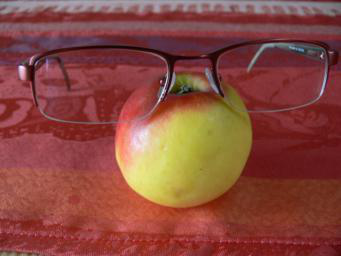

In [7]:
example['image']

3

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader

In [9]:
class SnackDataset(torch.utils.data.Dataset):

  def __init__(self, dataset):
        
      self.dataset = dataset
      
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

  def __len__(self):
      return len(self.dataset)
    
  def get_images(self, index):
      return self.transform(self.dataset[index]['image'])
  
  def get_labels(self, index):
      return self.dataset[index]['label']
  
  def __getitem__(self, index):
      train_images = self.get_images(index)
      train_labels = self.get_labels(index)
      return train_images, train_labels

In [10]:
train_dataset = SnackDataset(dataset["train"])
test_dataset = SnackDataset(dataset["test"])

4

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class_names = dataset["test"].features["label"].names
dataset_sizes = {
    'train': len(dataset['train']),
    'test': len(dataset['test']),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # "cuda:0" if torch.cuda.is_available() else 

5

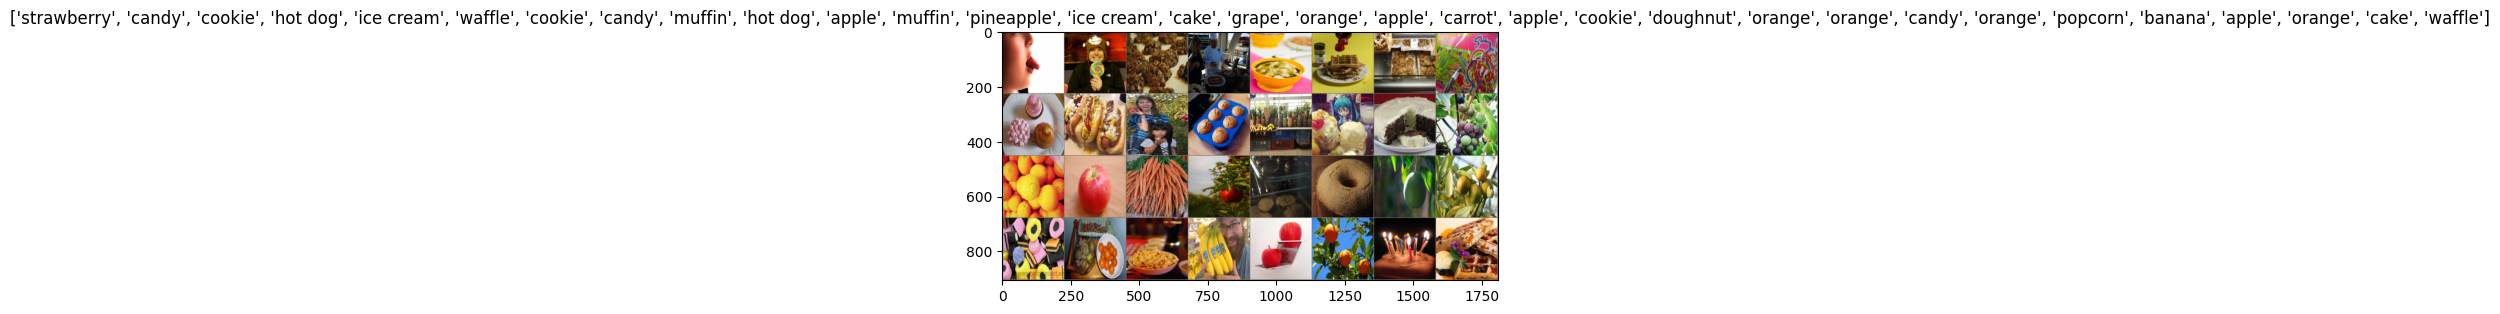

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

6

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} | Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [15]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 128, 3, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.Conv2d(128, 256, 3),
    nn.ReLU(),
    nn.Conv2d(256, 128, 3, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.BatchNorm2d(128),

    nn.Conv2d(128, 256, 3),
    nn.ReLU(),
    nn.Conv2d(256, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.BatchNorm2d(64),

    nn.Flatten(),

    nn.Linear(64 * 6 * 6, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
)


model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch [1/10]
----------
train Loss: 2.9323 | Accuracy: 0.1240
test Loss: 2.8335 | Accuracy: 0.1218

Epoch [2/10]
----------
train Loss: 2.6314 | Accuracy: 0.1804
test Loss: 2.5975 | Accuracy: 0.1964

Epoch [3/10]
----------
train Loss: 2.4705 | Accuracy: 0.2381
test Loss: 2.6168 | Accuracy: 0.2290

Epoch [4/10]
----------
train Loss: 2.1277 | Accuracy: 0.3289
test Loss: 2.3327 | Accuracy: 0.2836

Epoch [5/10]
----------
train Loss: 1.9521 | Accuracy: 0.3783
test Loss: 2.3156 | Accuracy: 0.2910

Epoch [6/10]
----------
train Loss: 1.8659 | Accuracy: 0.4029
test Loss: 2.3429 | Accuracy: 0.2815

Epoch [7/10]
----------
train Loss: 1.7549 | Accuracy: 0.4392
test Loss: 2.3156 | Accuracy: 0.3036

Epoch [8/10]
----------
train Loss: 1.7307 | Accuracy: 0.4518
test Loss: 2.3178 | Accuracy: 0.2973

Epoch [9/10]
----------
train Loss: 1.7325 | Accuracy: 0.4611
test Loss: 2.3208 | Accuracy: 0.2983

Epoch [10/10]
----------
train Loss: 1.7179 | Accuracy: 0.4554
test Loss: 2.3179 | Accuracy: 0.3004


In [16]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu") #"cuda" if use_cuda else 
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    output = model_fitted(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [17]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

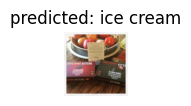

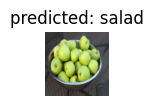

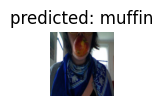

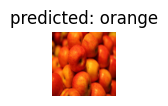

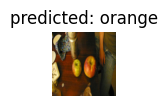

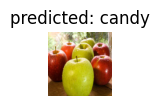

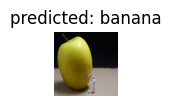

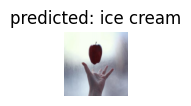

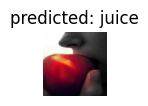

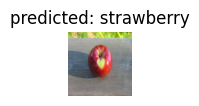

In [18]:
visualize_model(model_fitted, 10)

In [22]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [23]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch [1/10]
----------
train Loss: 1.7187 | Accuracy: 0.4504
test Loss: 2.3267 | Accuracy: 0.2920

Epoch [2/10]
----------
train Loss: 1.7168 | Accuracy: 0.4537
test Loss: 2.3263 | Accuracy: 0.2847

Epoch [3/10]
----------
train Loss: 1.7187 | Accuracy: 0.4613
test Loss: 2.3171 | Accuracy: 0.2941

Epoch [4/10]
----------
train Loss: 1.7148 | Accuracy: 0.4564
test Loss: 2.3255 | Accuracy: 0.2910

Epoch [5/10]
----------
train Loss: 1.7186 | Accuracy: 0.4492
test Loss: 2.3182 | Accuracy: 0.2962

Epoch [6/10]
----------
train Loss: 1.7178 | Accuracy: 0.4487
test Loss: 2.3157 | Accuracy: 0.2931

Epoch [7/10]
----------
train Loss: 1.7077 | Accuracy: 0.4541
test Loss: 2.3240 | Accuracy: 0.2920

Epoch [8/10]
----------
train Loss: 1.7133 | Accuracy: 0.4537
test Loss: 2.3220 | Accuracy: 0.2952

Epoch [9/10]
----------
train Loss: 1.7157 | Accuracy: 0.4589
test Loss: 2.3219 | Accuracy: 0.2962

Epoch [10/10]
----------
train Loss: 1.7219 | Accuracy: 0.4516
test Loss: 2.3135 | Accuracy: 0.2941


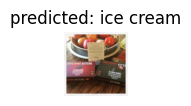

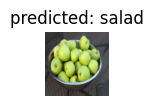

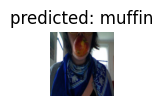

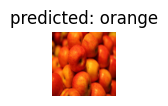

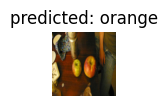

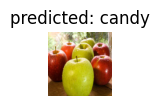

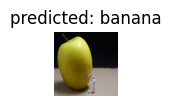

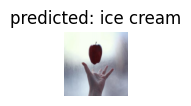

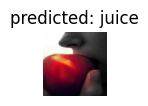

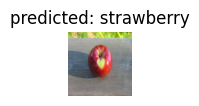

In [24]:
visualize_model(model_ft)